In [1]:
from   fundopt.fundopt import FundTargetRetMinCVaROptimiser, FundTargetRetMinVarianceOptimiser
import pandas   as pd
import numpy    as np
import datetime as dt
import cvxpy as cvx
import logging

In [16]:
start = dt.date(2020, 1, 1)
end   = dt.date(2021, 7, 30)
holding =  20

fund_returns = pd.read_pickle('./{}_{}_{}.pkl'.format(start, end, holding))

# Not tradeable
fund_returns.drop(['001487'], axis=1, inplace=True)

In [32]:
lookback_start = dt.date(2021, 1, 30)
lookback_end   = dt.date(2021, 7, 30)
lookback = pd.bdate_range(lookback_start, lookback_end)

print( f"Look back period from {lookback.min()} to {lookback.max()}" )
print( "Top 5 high return funds:")
print( fund_returns.reindex(lookback).fillna(0.0).mean(axis=0).sort_values(ascending=False).head() )

opt = FundTargetRetMinCVaROptimiser(
    targetRet=0.05, 
    returns=fund_returns)

current=pd.Series(dtype=float)
current['000198'] = 100000.0

solver_options = { 
    'verbose' : True,
    'solver'  : cvx.SCIP,
 }
opt_trade = opt.getOptimalPosition(current, lookbackPeriod=lookback, solver_options=solver_options)

Look back period from 2021-02-01 00:00:00 to 2021-07-30 00:00:00
Top 5 high return funds:
000689    0.078652
002296    0.075674
001298    0.074807
000209    0.069540
000828    0.065396
dtype: float64
                                     CVXPY                                     
                                    v1.1.12                                    
(CVXPY) Jul 31 07:24:59 PM: Your problem has 3508 variables, 3 constraints, and 1 parameters.
(CVXPY) Jul 31 07:24:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 31 07:24:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 31 07:25:00 PM: Compiling problem (target solver=SCIP).
(CVXPY) Jul 31 07:25:00 PM

In [18]:
target_rets = np.linspace(0.01, 0.07, 10)

In [19]:
solver_options = { 
    'verbose' : False,
    'solver'  : cvx.GLPK,
 }

In [20]:
res = []
for ret in target_rets:
    opt.set_target_ret_and_rerun(ret, solver_options)
    print(ret, opt.cvxProblem.value)
    res.append((ret, opt.cvxProblem.value))

0.01 -3101.927247793257
0.016666666666666666 -3101.9272477932577
0.023333333333333334 -3101.9272477932564
0.03 -3101.9272477932564
0.03666666666666667 -3018.1698671532195
0.043333333333333335 -2256.6339911209634
0.05 -417.41968913748127
0.05666666666666667 2323.969923310366
0.06333333333333334 5488.835422108391
0.07 16866.954606318654


In [21]:
import matplotlib.pyplot as plt

In [22]:
data = np.array(res)

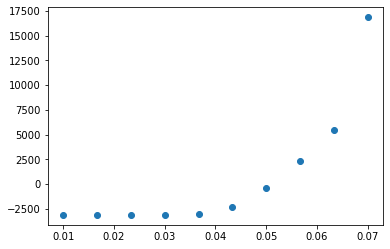

In [23]:
plt.scatter(data[:, 0], data[:, 1])

In [33]:
solver_options = { 
    'verbose' : True,
    'solver'  : cvx.SCIP,
 }
opt.set_target_ret_and_rerun(0.06, solver_options)
print(opt.cvxProblem.value)

                                     CVXPY                                     
                                    v1.1.12                                    
(CVXPY) Jul 31 07:26:29 PM: Your problem has 3508 variables, 3 constraints, and 1 parameters.
(CVXPY) Jul 31 07:26:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 31 07:26:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 31 07:26:29 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Jul 31 07:26:29 PM: Finished problem compilation (took 1.155e-02 seconds).
-------------------------------------------------------------------------------
                             

In [30]:
opt.set_target_ret_and_rerun(0.05, solver_options)
print(opt.cvxProblem.value)

                                     CVXPY                                     
                                    v1.1.12                                    
(CVXPY) Jul 31 05:20:26 PM: Your problem has 3508 variables, 3 constraints, and 1 parameters.
(CVXPY) Jul 31 05:20:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 31 05:20:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 31 05:20:26 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Jul 31 05:20:26 PM: Finished problem compilation (took 1.486e-02 seconds).
-------------------------------------------------------------------------------
                             

In [53]:
final = current.add(opt_trade, fill_value=0.0)

In [54]:
final = final[final.abs()>0.1]

In [55]:
from fundopt.fundtsloader import getTSLoader

In [56]:
rolled = {}
daily = {}
for symbol, value in final.iteritems():
    loader = getTSLoader(symbol)
    loader.load(lookback_start, lookback_end)
    ret_ts = loader.getReturnTS(lookback_start, lookback_end)
    rolled[symbol] = value * (1.+ret_ts).cumprod()

In [57]:
backtest = pd.DataFrame.from_dict( rolled )

<AxesSubplot:>

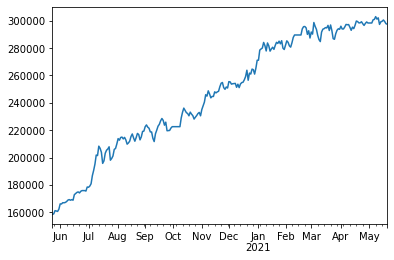

In [58]:
backtest.dropna().sum(axis=1).plot()

In [59]:
df1 = pd.read_pickle('2020-01-01_2021-05-21_20.pkl')
df2 = pd.read_pickle('2020-01-01_2021-05-21_20_v2.pkl')

In [63]:
df1.shape

(343, 3525)

In [69]:
new_symbols = df2.columns.difference(df1.columns)

<AxesSubplot:>

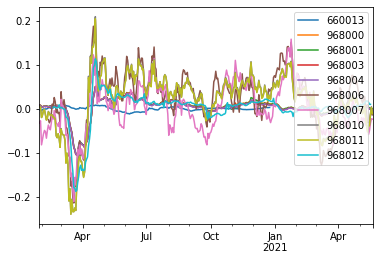

In [74]:
df2[new_symbols[-10:]].plot()

<AxesSubplot:>

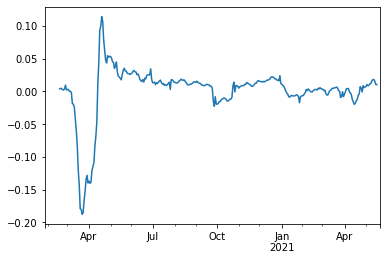

In [76]:
df2['968012'].plot()